#Packages

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import random
from torchvision.utils import make_grid
import torch.nn.functional as F
from tqdm import tqdm 
from torch.utils.data import random_split
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploring the Data

In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)
explore_ds = DataLoader(dataset,batch_size = 1,num_workers=2) 

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
data = iter(explore_ds) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")
print("Total No of Images in EMNIST dataset:", len(dataset) + len(test_dataset))
print("No of images in Training dataset:    ",len(dataset))
print("No of images in Testing dataset:     ",len(test_dataset))

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([1, 1, 28, 28]), torch.Size([1])
Labels: tensor([35])

Total No of Images in EMNIST dataset: 814255
No of images in Training dataset:     697932
No of images in Testing dataset:      116323


In [ ]:
l = dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  62
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# This helper funcation convert the output index [0-61] into character [0-9],[A-Z],[a-z]

def to_char(num):
    if num<10:
        return str(num)
    elif num < 36:
        return chr(num+55)
    else:
        return chr(num+61)


# This is reverse of above function. Convert character [0-9],[A-Z],[a-z] into index [0-61]
def to_index(char):
    if ord(char)<59:
        return ord(char)-48
    elif ord(char)<95:
        return ord(char)-55
    else:
        return ord(char)-61

In [ ]:
def show_example(data):
    img, label = data
    print("Label: ("+to_char(label)+")")
    plt.imshow(img[0], cmap="gray")

Label: (9)


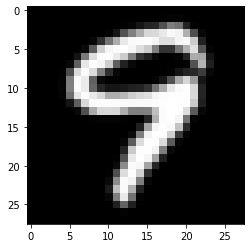

In [ ]:
show_example(dataset[random.randrange(len(dataset))])

# Basic setups

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
class CharacterClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print()
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        print()

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
 
    for epoch in tqdm(range(epochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader,
                              desc="iteration",
                              unit="%",
                              disable=True):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# AlexNet

In [ ]:
model_save_name = 'emnist-alexnet.pth'
path = F"/content/drive/MyDrive/Colab Notebooks/Data/" 

In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.Resize((224,224)),
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)

In [ ]:
# Set the random seed to get same random split
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [ ]:
batch_size = 400

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size*2, num_workers=2)


Training Batch: 


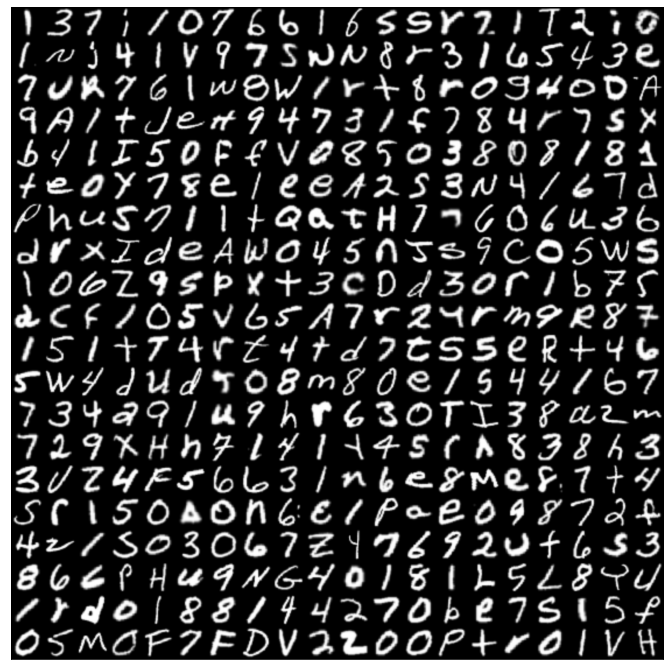

In [ ]:
# Lets see a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
print('Training Batch: ')
show_batch(train_dl)     


Validation Batch: 


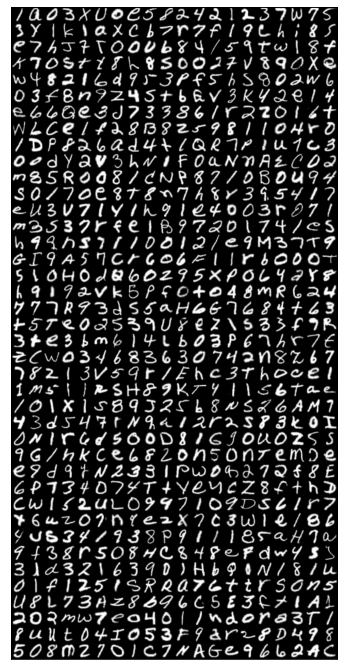

In [ ]:
print('Validation Batch: ')
show_batch(val_dl)

In [ ]:
class AlexNet(CharacterClassificationBase):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(AlexNet(num_classes = len(l)), device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Evaluate model without training

In [ ]:
result = [evaluate(model, val_dl)]
result

[{'val_acc': 0.0037365613970905542, 'val_loss': 4.127875328063965}]

In [ ]:
train_model = True

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [ ]:
%%time
if train_model:
    print("Training the model... \n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load(path + model_save_name, map_location=get_default_device())))
    print()

Training the model... 




Epoch:  12%|█▎        | 1/8 [07:29<52:25, 449.41s/epoch]


Epoch [0], last_lr: 0.00396, train_loss: 0.6916, val_loss: 0.4611, val_acc: 0.8368



Epoch:  25%|██▌       | 2/8 [15:04<45:18, 453.02s/epoch]


Epoch [1], last_lr: 0.00936, train_loss: 0.6260, val_loss: 0.5618, val_acc: 0.8115



Epoch:  38%|███▊      | 3/8 [22:36<37:40, 452.20s/epoch]


Epoch [2], last_lr: 0.00972, train_loss: 0.6582, val_loss: 0.5053, val_acc: 0.8225



Epoch:  50%|█████     | 4/8 [30:08<30:09, 452.28s/epoch]


Epoch [3], last_lr: 0.00812, train_loss: 0.5952, val_loss: 0.4679, val_acc: 0.8312



Epoch:  62%|██████▎   | 5/8 [37:36<22:32, 450.72s/epoch]


Epoch [4], last_lr: 0.00556, train_loss: 0.5351, val_loss: 0.4218, val_acc: 0.8487



Epoch:  75%|███████▌  | 6/8 [45:02<14:58, 449.19s/epoch]


Epoch [5], last_lr: 0.00283, train_loss: 0.4686, val_loss: 0.3800, val_acc: 0.8589



Epoch:  88%|████████▊ | 7/8 [52:29<07:28, 448.54s/epoch]


Epoch [6], last_lr: 0.00077, train_loss: 0.4110, val_loss: 0.3509, val_acc: 0.8690



Epoch: 100%|██████████| 8/8 [59:59<00:00, 449.94s/epoch]


Epoch [7], last_lr: 0.00000, train_loss: 0.3716, val_loss: 0.3389, val_acc: 0.8728

CPU times: user 15min 2s, sys: 5min 2s, total: 20min 4s
Wall time: 59min 59s


In [ ]:
def plot_accuracies(history):
    if train_model:
      accuracies = [x['val_acc'] for x in history]
      np.savetxt(path+'alexnet_history_val_acc.txt', accuracies)
    else:
      accuracies = np.loadtxt(path+'alexnet_history_val_acc.txt')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    if train_model:
      train_losses = [x.get('train_loss') for x in history]
      val_losses = [x['val_loss'] for x in history]
      np.savetxt(path+'alexnet_history_train_losses.txt', train_losses)
      np.savetxt(path+'alexnet_history_val_losses.txt', val_losses)
    else:
      train_losses = np.loadtxt(path+'alexnet_history_train_losses.txt')
      val_losses = np.loadtxt(path+'alexnet_history_val_losses.txt')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    if train_model:
      lrs = np.concatenate([x.get('lrs', []) for x in history])
      np.savetxt(path+'alexnet_history_lrs.txt', lrs)
    else:
      lrs = np.loadtxt(path+'alexnet_history_lrs.txt')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

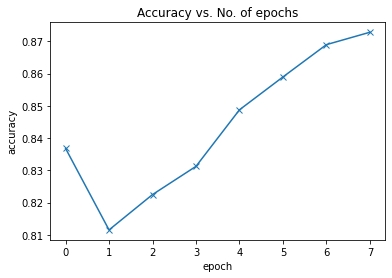

In [ ]:
if train_model:
  plot_accuracies(history)

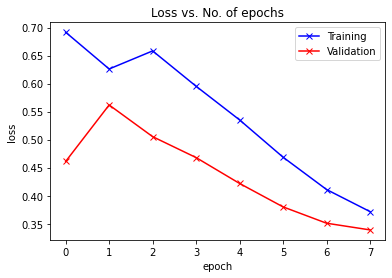

In [ ]:
if train_model:
  plot_losses(history)

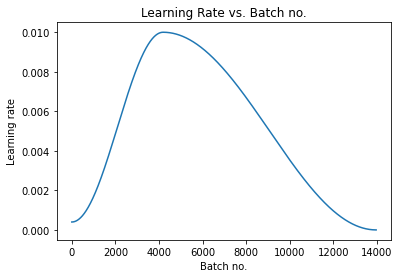

In [ ]:
if train_model:
  plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.8727961778640747
The final Loss of model on Test Dataset:     0.33891603350639343


Saving model

In [ ]:
if train_model:
  torch.save(model.state_dict(), path + model_save_name)
  